# MNIST Dataset

MeLIME explanations for a Convolutional Neural Networking (CNN) model. The model was trained using the MNIST Dataset.

In [1]:
import os, sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

from melime.generators.vae_gen import VAEGen
from melime.explainers.explainer import Explainer
from melime.explainers.visualizations.visualization import ImagePlot

import torch
import torch.utils.data
from torchvision import datasets, transforms
from utils import mnist_cnn

# Loadind data

In [2]:
batch_size = 128
cuda = True
kwargs = {"num_workers": 1, "pin_memory": True} if cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST("./data/", train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
        ])),
    batch_size=batch_size, shuffle=True, **kwargs)
    
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("./data/", train=False, download=True, 
            transform=transforms.Compose([
                transforms.ToTensor(),
        ])),
    batch_size=batch_size, **kwargs)

### ML Model - CNN using Torch

In [3]:
path_model = "pretrained/cnn_mnist.torch"
device = torch.device("cuda" if cuda else "cpu")
device_cpu = torch.device("cpu")
if os.path.exists(path_model):
    model = mnist_cnn.model_load(device, path=path_model)
else:
    model = mnist_cnn.train_model(
        train_loader, test_loader, device='cuda', path=path_model, epochs=20)

def model_predict(x_):
    # Creation of a prediction function to use in MeLIME. 
    if isinstance(x_, torch.Tensor):
        x_tf = x_
    else:
        x_tf = torch.from_numpy(x_)
    with torch.no_grad():
        x_tf = x_tf.reshape(-1, 1, 28, 28)
        y = model(x_tf.to(device=device))
        y = y.data.exp().to(device_cpu).numpy()
        return y

### MeLIME using KDEGen

In [4]:
generator = VAEGen(input_dim=784, verbose=True)
path_vaegen = "pretrained/vae_gen.melime"
if os.path.exists(path_vaegen):
    generator.load_manifold(path_vaegen)
else:
    generator.fit(train_loader, epochs=20)
    generator.save_manifold(path_vaegen)

In [5]:
batch_test = next(iter(test_loader))

In [6]:
def get_explanation(x_explain, class_to_explain, r=0.6):
    print("Explanation for: ", class_to_explain)
    print("Probability:", model_predict(x_explain)[0][class_to_explain])
    explain_linear = Explainer(
        model_predict=model_predict, generator=generator, local_model='SGD')
    explanation, contra = explain_linear.explain_instance(
            x_explain=x_explain,
            class_index=class_to_explain,  
            r=r,
            n_samples=1000,
            tol_importance=0.01,
            tol_error=0.01,
            include_x_explain_train=True
        )
    return explanation, contra

def plot_explanation(explanation, contra, x_explain=None, class_to_explain=0):
    return ImagePlot.plot_importance_contrafactual(
            explanation.explain(), contra, class_to_explain, x_explain=x_explain)

### Explain a nine

Predicted: 9 0.9998131
Top 3 predicted Class [9 7 4]


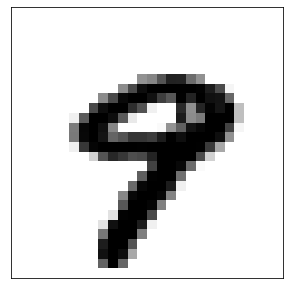

In [7]:
x_explain = batch_test[0][9].to(device_cpu).numpy()
y_explain = model_predict(x_explain)
y_explain_index = np.argmax(y_explain)
print('Predicted:', y_explain_index, y_explain[0][y_explain_index])
top_class = np.argsort(y_explain)[0][::-1]
print('Top 3 predicted Class', top_class[:3])
y = f'Prediction: {np.argmax(y_explain):}'
ImagePlot.plot_instances(x_explain.reshape(28,28))

Explanation for:  9
Probability: 0.9998131


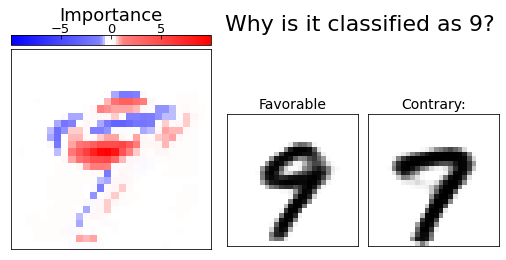

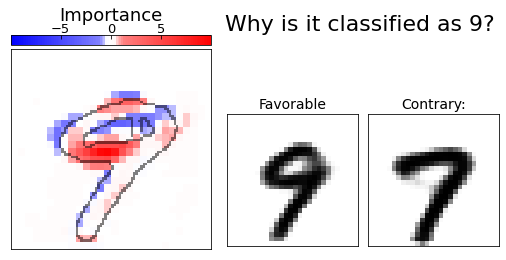

In [8]:
index = 0
explanation, contra = get_explanation(x_explain, top_class[index], r=1.0)
plot_explanation(explanation, contra, x_explain=None, class_to_explain=top_class[index])
plt.savefig(f"MNIST_number_9_e_c_{top_class[index]}.svg", dpi=300)
plot_explanation(explanation, contra, x_explain, top_class[index])
plt.savefig(f"MNIST_number_9_e_c_{top_class[index]}_mask.svg", dpi=300)

Explanation for:  7
Probability: 9.960698e-05


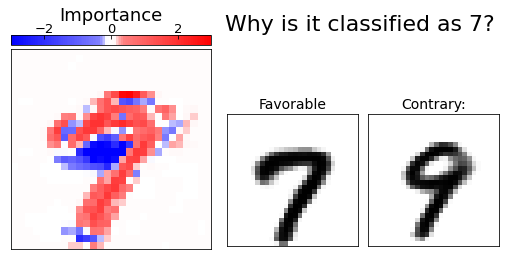

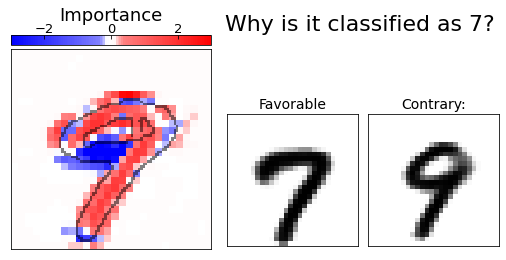

In [9]:
index = 1
explanation, contra = get_explanation(x_explain, top_class[index], r=1.0)
plot_explanation(explanation, contra, x_explain=None, class_to_explain=top_class[index])
plt.savefig(f"MNIST_number_9_e_c_{top_class[index]}.svg", dpi=300)
plot_explanation(explanation, contra, x_explain, top_class[index])
plt.savefig(f"MNIST_number_9_e_c_{top_class[index]}_mask.svg", dpi=300)

Explanation for:  4
Probability: 7.0327245e-05


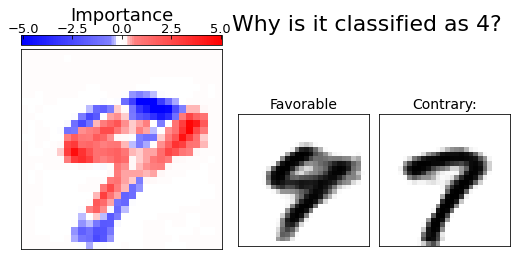

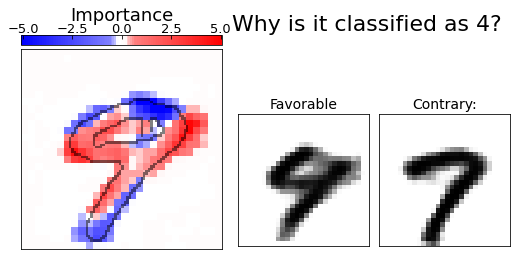

In [10]:
index = 2
explanation, contra = get_explanation(x_explain, top_class[index], r=1.0)
plot_explanation(explanation, contra, x_explain=None, class_to_explain=top_class[index])
plt.savefig(f"MNIST_number_9_e_c_{top_class[index]}.svg", dpi=300)
plot_explanation(explanation, contra, x_explain, top_class[index])
plt.savefig(f"MNIST_number_9_e_c_{top_class[index]}_mask.svg", dpi=300)

## Explain a Five

Predicted: 5 0.99992657
Top 3 predicted Class [5 3 6]


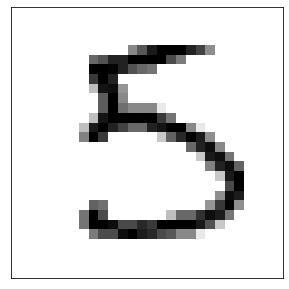

In [11]:
x_explain = batch_test[0][15].to(device_cpu).numpy()
y_explain = model_predict(x_explain)
y_explain_index = np.argmax(y_explain)
top_class = np.argsort(y_explain)[0][::-1]
print('Predicted:', y_explain_index, y_explain[0][y_explain_index])
print('Top 3 predicted Class', top_class[:3])
y = f'Prediction: {np.argmax(y_explain):}'
ImagePlot.plot_instances(x_explain.reshape(28,28))

Explanation for:  5
Probability: 0.99992657


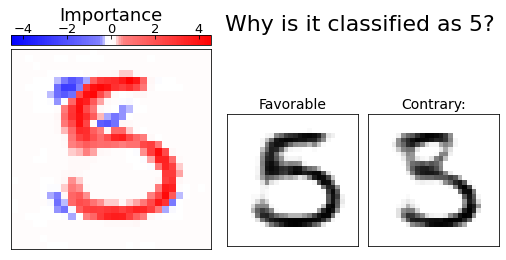

In [12]:
index = 0
explanation, contra = get_explanation(x_explain, top_class[index], r=1.0)
plot_explanation(explanation, contra, x_explain=None, class_to_explain=top_class[index])
plt.savefig(f"MNIST_number_5.svg", dpi=300)

Explanation for:  3
Probability: 7.1466086e-05


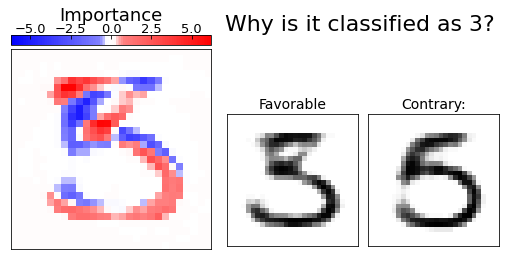

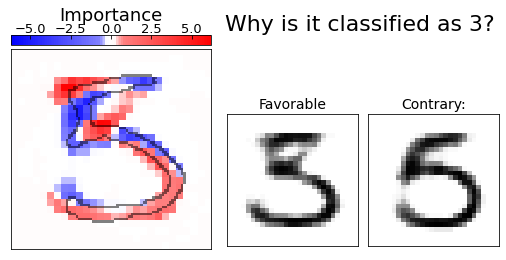

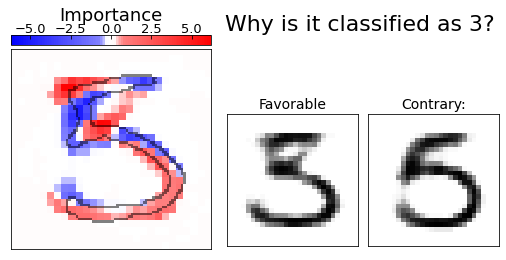

In [13]:
index = 1
explanation, contra = get_explanation(x_explain, top_class[index], r=1.0)
plot_explanation(explanation, contra, x_explain=None, class_to_explain=top_class[index])
plt.savefig(f"MNIST_number_5_e_c_{top_class[index]}.svg", dpi=300)
plot_explanation(explanation, contra, x_explain, top_class[index])
plt.savefig(f"MNIST_number_5_e_c_{top_class[index]}_mask.svg", dpi=300)
plot_explanation(explanation, contra, x_explain, top_class[index])
plt.savefig(f"MNIST_number_5_e_c_{top_class[index]}_mask.svg", dpi=300)

Explanation for:  6
Probability: 1.2977479e-06


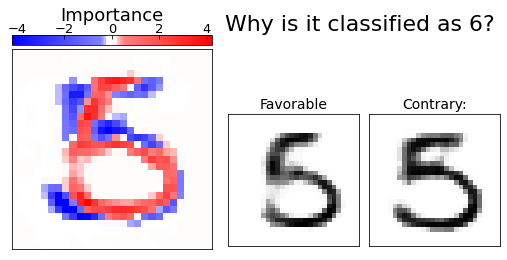

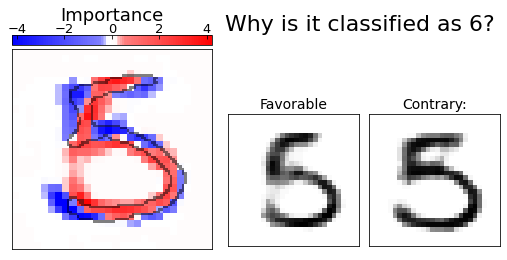

In [14]:
index = 2
explanation, contra = get_explanation(x_explain, top_class[index], r=1.0)
plot_explanation(explanation, contra, x_explain=None, class_to_explain=top_class[index])
plt.savefig(f"MNIST_number_5_e_c_{top_class[index]}.svg", dpi=300)
plot_explanation(explanation, contra, x_explain, top_class[index])
plt.savefig(f"MNIST_number_5_e_c_{top_class[index]}_mask.svg", dpi=300)

### Explain another five

Predicted: 5 0.99714637
Top 3 predicted Class [5 9 8]


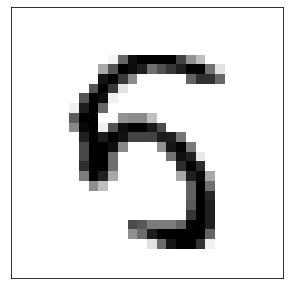

In [15]:
x_explain = np.loadtxt('five_example_1.np').astype(np.float32).reshape(1, 28, 28)
y_explain = model_predict(x_explain)
y_explain_index = np.argmax(y_explain)
print('Predicted:', y_explain_index, y_explain[0][y_explain_index])
top_class = np.argsort(y_explain)[0][::-1]
print('Top 3 predicted Class', top_class[:3])
y = f'Prediction: {np.argmax(y_explain):}'
ImagePlot.plot_instances(x_explain.reshape(28,28))
plt.savefig(f"MNIST_number_5_file.svg", dpi=300)

Explanation for:  5
Probability: 0.99714637


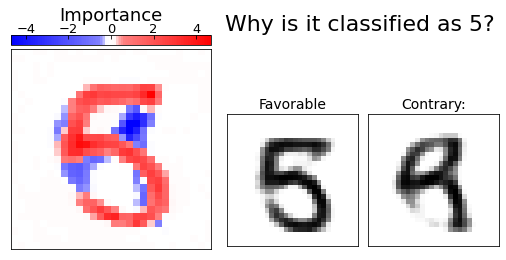

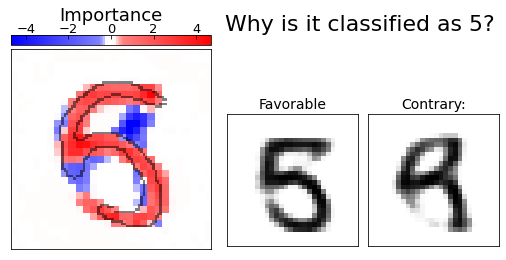

In [16]:
index = 0
explanation, contra = get_explanation(x_explain, top_class[index])
plot_explanation(explanation, contra, x_explain=None, class_to_explain=top_class[index])
plt.savefig(f"MNIST_number_5_file_e_c_{top_class[index]}.svg", dpi=300)
plot_explanation(explanation, contra, x_explain, top_class[index])
plt.savefig(f"MNIST_number_5_file_e_c_{top_class[index]}_mask.svg", dpi=300)

Explanation for:  9
Probability: 0.0020179239


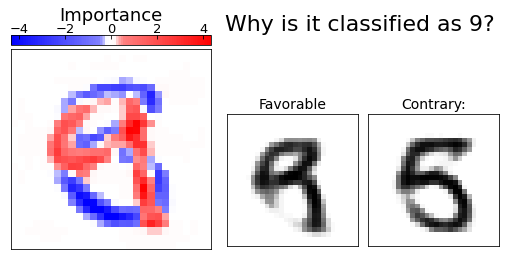

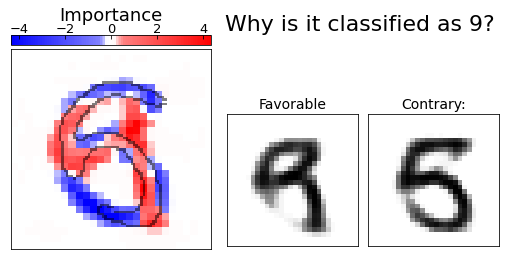

In [17]:
index = 1
explanation, contra = get_explanation(x_explain, top_class[index])
plot_explanation(explanation, contra, x_explain=None, class_to_explain=top_class[index])
plt.savefig(f"MNIST_number_5_file_e_c_{top_class[index]}.svg", dpi=300)
plot_explanation(explanation, contra, x_explain, top_class[index])
plt.savefig(f"MNIST_number_5_file_e_c_{top_class[index]}_mask.svg", dpi=300)

Explanation for:  8
Probability: 0.00082200026


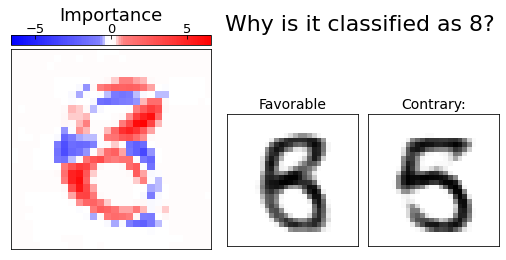

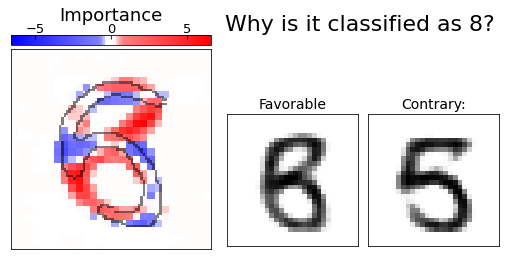

In [18]:
index = 2
explanation, contra = get_explanation(x_explain, top_class[index])
plot_explanation(explanation, contra, x_explain=None, class_to_explain=top_class[index])
plt.savefig(f"MNIST_number_5_file_e_c_{top_class[index]}.svg", dpi=300)
plot_explanation(explanation, contra, x_explain, top_class[index])
plt.savefig(f"MNIST_number_5_file_e_c_{top_class[index]}_mask.svg", dpi=300)

# Explaining another number 5

In [19]:
x_explain = np.loadtxt('five_example_2.np').astype(np.float32).reshape(1, 28, 28)
y_explain = model_predict(x_explain)
y_explain_index = np.argmax(y_explain)
print('predicted:', y_explain_index, y_explain[0][y_explain_index])
top_class = np.argsort(y_explain)[0][::-1]
print('Top 3 predicted Class', top_class[:3])
y = f'Prediction: {np.argmax(y_explain)}'

predicted: 5 0.9815022
Top 3 predicted Class [5 3 9]


Explanation for:  5
Probability: 0.9815022


(<Figure size 504x252 with 4 Axes>,
  <matplotlib.axes._axes.Axes at 0x7fb0c80e10d0>])

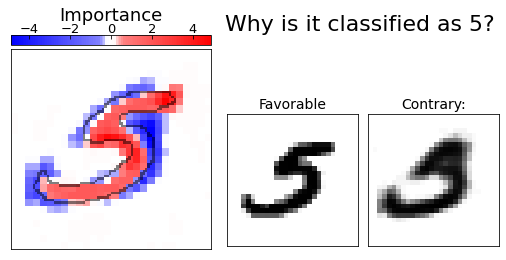

In [20]:
index = 0
explanation, contra = get_explanation(x_explain, top_class[index])
plot_explanation(explanation, contra, x_explain, top_class[index])

Explanation for:  3
Probability: 0.0114114415


(<Figure size 504x252 with 4 Axes>,
  <matplotlib.axes._axes.Axes at 0x7fb0a870b2d0>])

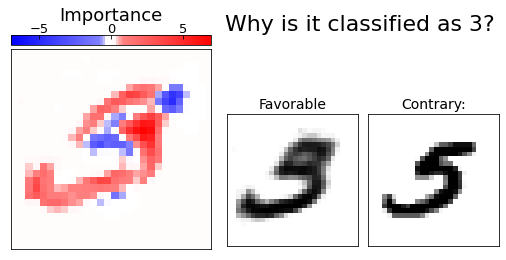

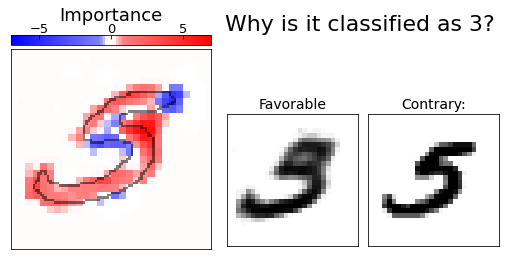

In [21]:
index = 1
explanation, contra = get_explanation(x_explain, top_class[index])
plot_explanation(explanation, contra, x_explain=None, class_to_explain=top_class[index])
plot_explanation(explanation, contra, x_explain, top_class[index])

Explanation for:  9
Probability: 0.0070658852


(<Figure size 504x252 with 4 Axes>,
  <matplotlib.axes._axes.Axes at 0x7fb0a85fb210>])

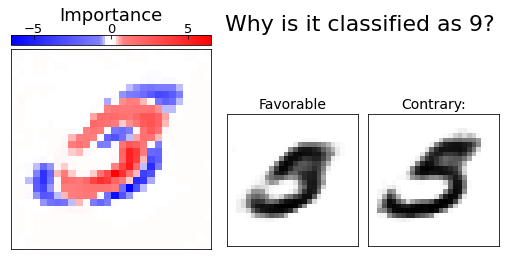

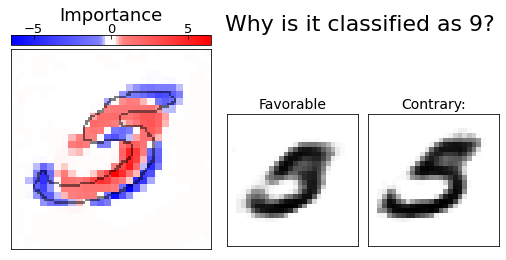

In [22]:
index = 2
explanation, contra = get_explanation(x_explain, top_class[index])
plot_explanation(explanation, contra, x_explain=None, class_to_explain=top_class[index])
plot_explanation(explanation, contra, x_explain, top_class[index])

# Explaining a number 3

In [23]:
x_explain = np.loadtxt('three_example.np').astype(np.float32).reshape(1, 28, 28)
y_explain = model_predict(x_explain)
y_explain_index = np.argmax(y_explain)
print('predicted:', y_explain_index, y_explain[0][y_explain_index])
top_class = np.argsort(y_explain)[0][::-1]
print('Top 3 predicted Class', top_class[:3])
y = f'Prediction: {np.argmax(y_explain):}'

predicted: 3 0.9921223
Top 3 predicted Class [3 9 5]


Explanation for:  3
Probability: 0.9921223


(<Figure size 504x252 with 4 Axes>,
  <matplotlib.axes._axes.Axes at 0x7fb0a87a5c50>])

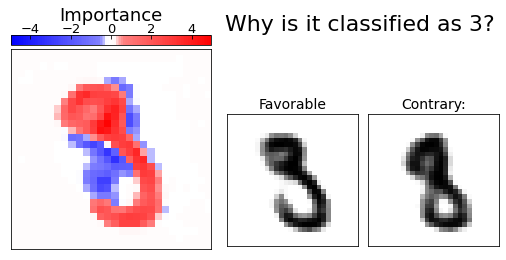

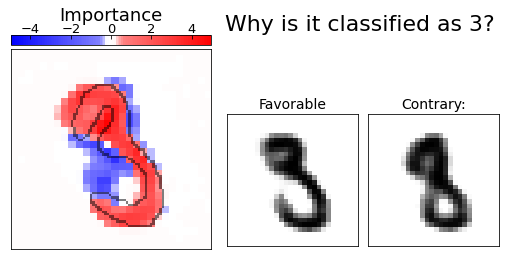

In [24]:
index = 0
explanation, contra = get_explanation(x_explain, top_class[index])
plot_explanation(explanation, contra, x_explain=None, class_to_explain=top_class[index])
plot_explanation(explanation, contra, x_explain, top_class[index])

Explanation for:  9
Probability: 0.0039527495


(<Figure size 504x252 with 4 Axes>,
  <matplotlib.axes._axes.Axes at 0x7fb0a8456850>])

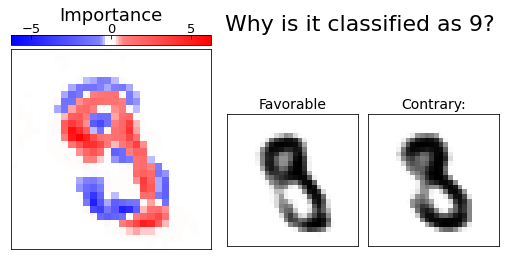

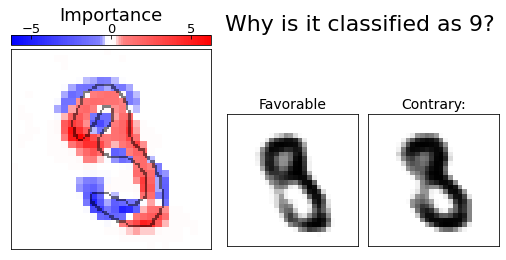

In [25]:
index = 1
explanation, contra = get_explanation(x_explain, top_class[index])
plot_explanation(explanation, contra, x_explain=None, class_to_explain=top_class[index])
plot_explanation(explanation, contra, x_explain, top_class[index])

Explanation for:  5
Probability: 0.0021701741


(<Figure size 504x252 with 4 Axes>,
  <matplotlib.axes._axes.Axes at 0x7fb0a862f990>])

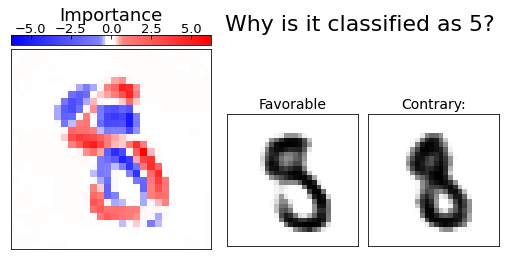

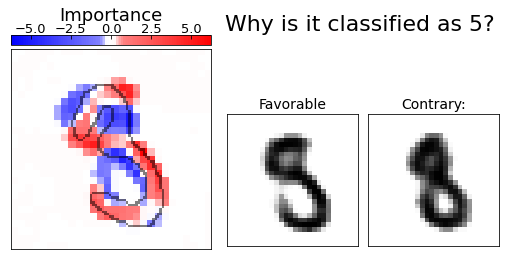

In [26]:
index = 2
explanation, contra = get_explanation(x_explain, top_class[index])
plot_explanation(explanation, contra, x_explain=None, class_to_explain=top_class[index])
plot_explanation(explanation, contra, x_explain, top_class[index])

Explanation for:  8
Probability: 0.0016541191


(<Figure size 504x252 with 4 Axes>,
  <matplotlib.axes._axes.Axes at 0x7fb0a8355b10>])

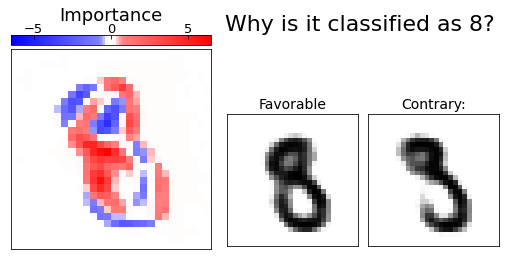

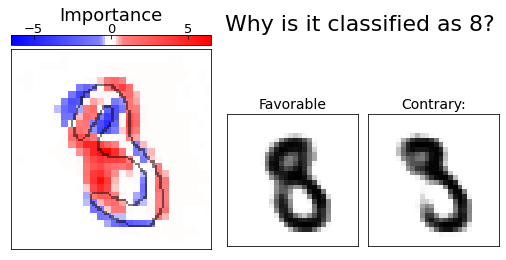

In [27]:
index = 3
explanation, contra = get_explanation(x_explain, top_class[index])
plot_explanation(explanation, contra, x_explain=None, class_to_explain=top_class[index])
plot_explanation(explanation, contra, x_explain, top_class[index])

Thank you!